## Setup and Imports

In [1]:
# Standard library imports
import os
import sys
from pathlib import Path
from typing import List

# Environment configuration
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["PYOPENGL_PLATFORM"] = "egl"

# Set rendering backend
if sys.platform == "darwin":
    os.environ["MUJOCO_GL"] = "glfw"
    print("Using macOS with GLFW rendering")
else:
    os.environ["MUJOCO_GL"] = "egl"
    print("Using Linux with EGL rendering")

import warnings

# Suppress pyEDM warnings about no valid prediction indices
warnings.filterwarnings('ignore', message='Simplex: PredictionValid.*')

# Third-party imports
import h5py
import jax
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import mediapy as media
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import mujoco
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

# HuggingFace imports
import huggingface_hub as hf_hub

# Logging configuration
from absl import logging as absl_logging
absl_logging.set_verbosity(absl_logging.ERROR)

# Local/project imports
from track_mjx.agent import checkpointing
from track_mjx.analysis import rollout, render

# Set plot style
plt.style.use('seaborn-v0_8')
colorblind_colors = ['#1f77b4', "#ef7307", '#8E44AD']  # Blue, Orange, Purple

def get_joint_qpos(model, qposes, joint_name):
    """Get qpos value(s) for a specific joint by name."""
    joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, joint_name)
    if joint_id == -1:
        print(f"Joint '{joint_name}' not found!")
        return None

    qpos_addr = model.jnt_qposadr[joint_id]
    joint_type = model.jnt_type[joint_id]

    if joint_type == mujoco.mjtJoint.mjJNT_FREE:
        return qposes[:, qpos_addr : qpos_addr + 7]
    elif joint_type == mujoco.mjtJoint.mjJNT_HINGE:
        return qposes[:, qpos_addr]
    elif joint_type == mujoco.mjtJoint.mjJNT_BALL:
        return qposes[:, qpos_addr : qpos_addr + 4]
    else:
        return qposes[:, qpos_addr]

Using Linux with EGL rendering


## Download checkpoint data 

In [3]:
# Download both model checkpoints from HuggingFace
model_local_dir = Path("checkpoints")  # Use relative path in workspace

# Download Physics-Aware checkpoint
physics_download_dir = hf_hub.snapshot_download(
    repo_id="talmolab/mouse-reach-mjx-neurips", 
    repo_type="model",
    allow_patterns="checkpoints/physics-aware/*",
    local_dir=Path.cwd()
)
print(f"Downloaded Physics-Aware model to {physics_download_dir}")

# Download Joint Reward Only checkpoint
joint_download_dir = hf_hub.snapshot_download(
    repo_id="talmolab/mouse-reach-mjx-neurips", 
    repo_type="model",
    allow_patterns="checkpoints/joints_only/*",
    local_dir=Path.cwd()
)
print(f"Downloaded Joint Reward Only model to {joint_download_dir}")

# Set checkpoint paths - files download to current directory + pattern path
ckpt_path = Path.cwd() / "checkpoints" / "physics-aware" 
joint_ckpt_path = Path.cwd() / "checkpoints" / "joints_only" 

print(f"\nPhysics-Aware checkpoint: {ckpt_path}")
print(f"  Exists: {ckpt_path.exists()}")
print(f"Joint Reward Only checkpoint: {joint_ckpt_path}")
print(f"  Exists: {joint_ckpt_path.exists()}")
print(f"  Exists: {ckpt_path.exists()}")
print(f"Joint Reward Only checkpoint: {joint_ckpt_path}")
print(f"  Exists: {joint_ckpt_path.exists()}")

Fetching 25 files:   0%|          | 0/25 [00:00<?, ?it/s]

Downloaded Physics-Aware model to /root/vast/eric/mouse-reach-mjx-neurips


Fetching 23 files:   0%|          | 0/23 [00:00<?, ?it/s]

Downloaded Joint Reward Only model to /root/vast/eric/mouse-reach-mjx-neurips

Physics-Aware checkpoint: /root/vast/eric/mouse-reach-mjx-neurips/checkpoints/physics-aware
  Exists: True
Joint Reward Only checkpoint: /root/vast/eric/mouse-reach-mjx-neurips/checkpoints/joints_only
  Exists: True
  Exists: True
Joint Reward Only checkpoint: /root/vast/eric/mouse-reach-mjx-neurips/checkpoints/joints_only
  Exists: True


## Download Reference Data

In [4]:
# Download all mouse_arm data files from HuggingFace
data_local_dir = Path.cwd().parent
data_download_dir = hf_hub.snapshot_download(
    repo_id="talmolab/MIMIC-MJX", 
    repo_type="dataset",
    allow_patterns="data/mouse_arm/*.h5",
    local_dir=data_local_dir
)
print(f"Downloaded all mouse_arm data to {data_download_dir}")

# List downloaded files
mouse_arm_dir = Path(data_download_dir) / "data" / "mouse_arm"
h5_files = list(mouse_arm_dir.glob("*.h5"))
print(f"Found {len(h5_files)} H5 files")

Fetching 46 files:   0%|          | 0/46 [00:00<?, ?it/s]

Downloaded all mouse_arm data to /root/vast/eric
Found 46 H5 files


## Load Checkpoint and Configure Environment

In [5]:
# Load the Physics-Aware checkpoint at step 2
ckpt = checkpointing.load_checkpoint_for_eval(ckpt_path)
cfg = ckpt["cfg"]

# Load the Joint Reward Only checkpoint at step 2
joint_ckpt = checkpointing.load_checkpoint_for_eval(joint_ckpt_path)
joint_cfg = joint_ckpt["cfg"]

# Update the data path to the downloaded reference data
if h5_files:
    cfg.data_path = ",".join(str(f) for f in sorted(h5_files))
    joint_cfg.data_path = ",".join(str(f) for f in sorted(h5_files))
    print(f"Using {len(h5_files)} data files")
else:
    print("No H5 files found!")


Loading checkpoint from /root/vast/eric/mouse-reach-mjx-neurips/checkpoints/physics-aware at step 2
Loading checkpoint from /root/vast/eric/mouse-reach-mjx-neurips/checkpoints/joints_only at step 2
Using 46 data files


## Create Environment and Rollout Generator

In [6]:
# Create environment and rollout generator for Physics-Aware model
env = rollout.create_environment(cfg)
inference_fn = checkpointing.load_inference_fn(cfg, ckpt["policy"])
generate_rollout = rollout.create_rollout_generator(
    cfg, 
    env, 
    inference_fn, 
    log_activations=True, 
    log_metrics=True, 
    log_sensor_data=True,
)

# Create environment and rollout generator for Joint Reward Only model
joint_env = rollout.create_environment(joint_cfg)
joint_inference_fn = checkpointing.load_inference_fn(joint_cfg, joint_ckpt["policy"])
joint_generate_rollout = rollout.create_rollout_generator(
    joint_cfg, 
    joint_env, 
    joint_inference_fn, 
    log_activations=True, 
    log_metrics=True, 
    log_sensor_data=True,
)


## Generate Rollout

Generate a single rollout using clip index 20 from the reference data. This will simulate the mouse's reaching behavior based on the trained policy. Feel free to change the clip index to visualize different behaviors in this dataset.

> **Note:** The first time you run this cell, it may take up to 2 minutes to compile the model with JAX, depending on your hardware. Subsequent runs will be much faster.

In [7]:
# generate a single rollout
single_rollout = generate_rollout(clip_idx=20)

## Render and Save Video

Render the rollout as video frames and save it as an MP4 file. The video will be saved in the checkpoint directory.

In [8]:
# render single rollout 
frames, realtime_framerate = render.render_rollout(
    cfg, 
    single_rollout, 
    height=480,
    width=640,
)

# save the video to disk
media.write_video(Path(ckpt_path) / "rollout.mp4", frames, fps=50)
media.show_video(frames, fps=50)

MuJoCo Rendering with Ghost Model...
Rendering every 1 steps; realtime fps: 500


100%|██████████| 120/120 [00:00<00:00, 539.01it/s]


## Generate Batch Rollouts

Generate rollouts for all clips in parallel using JAX's vectorized execution.

In [9]:
# Enable JAX compilation cache for faster subsequent runs
persistent_cache = True
if persistent_cache:
    jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
    jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
    jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
    jax.config.update(
        "jax_persistent_cache_enable_xla_caches",
        "xla_gpu_per_fusion_autotune_cache_dir",
    )

# Create JIT-compiled vectorized rollout functions
jit_vmap_generate_rollout = jax.jit(jax.vmap(generate_rollout))
jit_vmap_joint_generate_rollout = jax.jit(jax.vmap(joint_generate_rollout))

# Generate rollouts for all 46 clips
start_idx, end_idx = 0, 46
clip_idxs = np.arange(start_idx, end_idx)

print("Generating Physics-Aware model rollouts...")
batch_rollout = jit_vmap_generate_rollout(clip_idxs)
print(f"  Keys available: {list(batch_rollout.keys())}")
print(f"  Actions shape: {batch_rollout['ctrl'].shape}")
print(f"  Qpos rollout shape: {batch_rollout['qposes_rollout'].shape}")

print("\nGenerating Joint Reward Only model rollouts...")
joint_batch_rollout = jit_vmap_joint_generate_rollout(clip_idxs)
print(f"  Keys available: {list(joint_batch_rollout.keys())}")
print(f"  Actions shape: {joint_batch_rollout['ctrl'].shape}")
print(f"  Qpos rollout shape: {joint_batch_rollout['qposes_rollout'].shape}")


Generating Physics-Aware model rollouts...
  Keys available: ['activations', 'ctrl', 'joint_forces', 'qposes_ref', 'qposes_rollout', 'rollout_metrics', 'sensor_readings', 'state_rewards']
  Actions shape: (46, 119, 9)
  Qpos rollout shape: (46, 120, 4)

Generating Joint Reward Only model rollouts...
  Keys available: ['activations', 'ctrl', 'joint_forces', 'qposes_ref', 'qposes_rollout', 'rollout_metrics', 'sensor_readings', 'state_rewards']
  Actions shape: (46, 119, 9)
  Qpos rollout shape: (46, 120, 4)


## Save Rollout Data to H5 File

Save the batch rollout data in a format compatible with the EMG analysis scripts.

In [10]:
# Save rollout data to H5 files for both models

# 1. Save Physics-Aware model rollouts
output_h5_path_physics = ckpt_path / "rollouts_full_mouse_arm_physics_aware.h5"

with h5py.File(output_h5_path_physics, "w") as f:
    # Save actions (muscle activations) - this is the 'ctrl' field from batch_rollout
    f.create_dataset("actions", data=np.array(batch_rollout["ctrl"]))
    
    # Save qpos data
    f.create_dataset("qposes_rollout", data=np.array(batch_rollout["qposes_rollout"]))
    f.create_dataset("qposes_ref", data=np.array(batch_rollout["qposes_ref"]))
    
    # Save activations if available
    if "activations" in batch_rollout:
        activations_group = f.create_group("activations")
        
        # Save decoder activations
        if "decoder" in batch_rollout["activations"]:
            decoder_group = activations_group.create_group("decoder")
            for key, value in batch_rollout["activations"]["decoder"].items():
                decoder_group.create_dataset(key, data=np.array(value))
        
        # Save intention activations
        if "intention" in batch_rollout["activations"]:
            activations_group.create_dataset("intention", data=np.array(batch_rollout["activations"]["intention"]))

print(f"Saved Physics-Aware rollout data to: {output_h5_path_physics}")
print(f"  Actions shape: {batch_rollout['ctrl'].shape}")

# 2. Save Joint Reward Only model rollouts
output_h5_path_joint = joint_ckpt_path / "rollouts_full_mouse_arm_joint_only.h5"

with h5py.File(output_h5_path_joint, "w") as f:
    # Save actions (muscle activations) - this is the 'ctrl' field from joint_batch_rollout
    f.create_dataset("actions", data=np.array(joint_batch_rollout["ctrl"]))
    
    # Save qpos data
    f.create_dataset("qposes_rollout", data=np.array(joint_batch_rollout["qposes_rollout"]))
    f.create_dataset("qposes_ref", data=np.array(joint_batch_rollout["qposes_ref"]))
    
    # Save activations if available
    if "activations" in joint_batch_rollout:
        activations_group = f.create_group("activations")
        
        # Save decoder activations
        if "decoder" in joint_batch_rollout["activations"]:
            decoder_group = activations_group.create_group("decoder")
            for key, value in joint_batch_rollout["activations"]["decoder"].items():
                decoder_group.create_dataset(key, data=np.array(value))
        
        # Save intention activations
        if "intention" in joint_batch_rollout["activations"]:
            activations_group.create_dataset("intention", data=np.array(joint_batch_rollout["activations"]["intention"]))

print(f"Saved Joint Reward Only rollout data to: {output_h5_path_joint}")
print(f"  Actions shape: {joint_batch_rollout['ctrl'].shape}")

Saved Physics-Aware rollout data to: /root/vast/eric/mouse-reach-mjx-neurips/checkpoints/physics-aware/rollouts_full_mouse_arm_physics_aware.h5
  Actions shape: (46, 119, 9)
Saved Joint Reward Only rollout data to: /root/vast/eric/mouse-reach-mjx-neurips/checkpoints/joints_only/rollouts_full_mouse_arm_joint_only.h5
  Actions shape: (46, 119, 9)


## Joint Angle Tracking Visualization

Compare reference joint angles with simulation rollout for individual clips.

In [11]:
def plot_joint_angles_comparison(
    qpos_sim,
    qpos_ref, 
    clip_id=0,
    joint_indices=None,
    joint_names=None,
    joint_labels=None,
    save_path=None,
    sim_hz=200,
    max_time=0.25,
    model_name="Simulation",
    model_color=None,
):
    """Plot reference vs rollout joint angles for a given clip.
    
    Args:
        qpos_sim: Simulation qpos array (clips, T, nq)
        qpos_ref: Reference qpos array (clips, T, nq)
        clip_id: Clip index to visualize
        joint_indices: Joint indices to plot
        joint_names: Names for titles
        joint_labels: Labels for y-axis
        save_path: PDF/PNG path to save
        sim_hz: Simulation sampling rate
        max_time: Maximum time to plot in seconds
        model_name: Name of the model for legend
        model_color: Color for the model line
        
    Returns:
        matplotlib.figure.Figure
    """
    # Set default values
    if joint_indices is None:
        joint_indices = [0, 1, 2, 3]
    if joint_names is None:
        joint_names = ["sh_elv", "sh_ext", "sh_rot", "elbow"]
    if joint_labels is None:
        joint_labels = ["Sh Elevation", "Sh Extension", "Sh Rotation", "Elbow"]
    if model_color is None:
        model_color = colorblind_colors[0]
    
    # Extract clip data
    if clip_id >= qpos_sim.shape[0]:
        raise IndexError(f"clip_id {clip_id} out of range (total={qpos_sim.shape[0]}).")
    
    sim_clip = qpos_sim[clip_id]  # (T, nq)
    ref_clip = qpos_ref[clip_id]  # (T, nq)
    
    # Align DOFs if shapes differ
    nq = min(sim_clip.shape[1], ref_clip.shape[1])
    sim_clip = sim_clip[:, :nq]
    ref_clip = ref_clip[:, :nq]
    
    # Ensure same time length
    min_T = min(sim_clip.shape[0], ref_clip.shape[0])
    sim_clip = sim_clip[:min_T]
    ref_clip = ref_clip[:min_T]
    
    # Create time axis and filter by max_time
    time = np.arange(min_T) / float(sim_hz)
    
    if max_time is not None:
        time_idx = np.searchsorted(time, max_time, side='right')
        time = time[:time_idx]
        sim_clip = sim_clip[:time_idx]
        ref_clip = ref_clip[:time_idx]
    
    # Calculate global y-limits across all joints
    all_vals = []
    for j in joint_indices:
        all_vals.extend(np.degrees(sim_clip[:, j][np.isfinite(sim_clip[:, j])]))
        all_vals.extend(np.degrees(ref_clip[:, j][np.isfinite(ref_clip[:, j])]))
    
    if not all_vals:
        raise ValueError("No finite joint angle data to plot.")
    
    y_min = np.min(all_vals) - 5
    y_max = np.max(all_vals) + 5
    
    # Create figure
    fig, axes = plt.subplots(len(joint_indices), 1, figsize=(3, 8), sharex=True)
    axes = np.atleast_1d(axes)
    
    # Plot each joint
    for i, (j, name, label) in enumerate(zip(joint_indices, joint_names, joint_labels)):
        # Convert to degrees
        ref_deg = np.degrees(ref_clip[:, j])
        sim_deg = np.degrees(sim_clip[:, j])
        
        # Create masks for valid data
        ref_mask = np.isfinite(ref_deg)
        sim_mask = np.isfinite(sim_deg)
        both = ref_mask & sim_mask
        
        # Plot reference
        axes[i].plot(time[ref_mask], ref_deg[ref_mask],
                    color=colorblind_colors[2], label="Reference", linewidth=3, linestyle='--', alpha=0.8)
        
        # Plot simulation
        axes[i].plot(time[sim_mask], sim_deg[sim_mask],
                    color=model_color, label=model_name, linewidth=3)
        
        # Highlight difference
        if np.any(both):
            axes[i].fill_between(time[both], ref_deg[both], sim_deg[both],
                                alpha=0.2, color="gray")
        
        # Configure appearance
        axes[i].set_ylabel(f"{label} (°)", fontsize=18)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_title(f"{name}", fontsize=20, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='both', which='major', labelsize=14)
        
        if max_time is not None:
            axes[i].set_xlim(0, max_time)
        else:
            axes[i].set_xlim(0, time[-1])
        
        # Legend on first subplot
        if i == 0:
            axes[i].legend(loc='upper right', fontsize=14)
    
    # X-axis label
    axes[-1].set_xlabel("Time (seconds)", fontsize=18)
    
    plt.suptitle(f"{model_name}: Joint Angle Tracking (Clip {clip_id})", 
                fontsize=22, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    
    return fig

Creating joint angle tracking plot for both models (clip 0)...


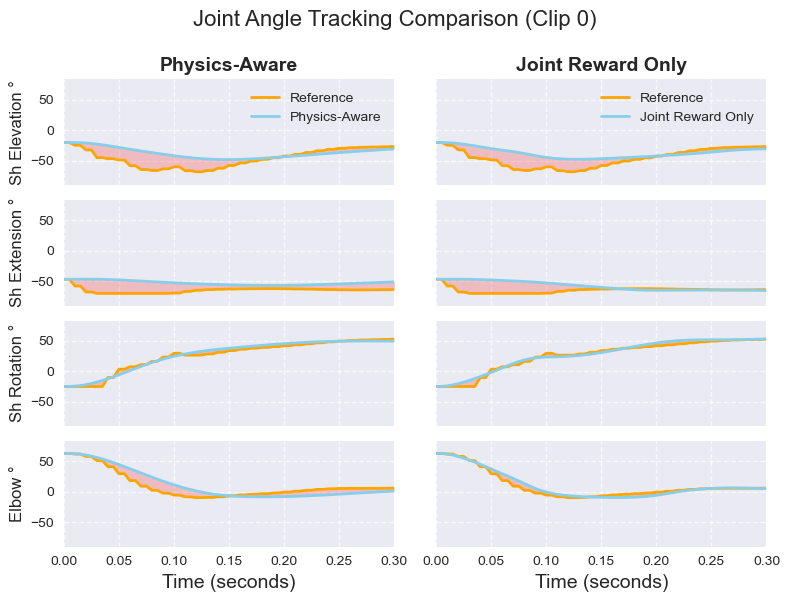

Saved joint angle comparison plot to: /root/vast/eric/mouse-reach-mjx-neurips/checkpoints/physics-aware/joint_angle_tracking_comparison_clip0.pdf


In [12]:
# Configuration for joint angle plotting
CLIP_ID = 0  # Clip index to visualize
JOINT_INDICES = [0, 1, 2, 3]  # Joint indices to plot
JOINT_NAMES = ["sh_elv", "sh_ext", "sh_rot", "elbow"]
JOINT_LABELS = ["Sh Elevation", "Sh Extension", "Sh Rotation", "Elbow"]
MAX_TIME = 0.3  # Only show first 250ms

# Create side-by-side comparison plot (2 columns, 4 rows)
print(f"Creating joint angle tracking plot for both models (clip {CLIP_ID})...")

# Extract data
physics_qpos_sim = batch_rollout["qposes_rollout"]
physics_qpos_ref = batch_rollout["qposes_ref"]
joint_qpos_sim = joint_batch_rollout["qposes_rollout"]
joint_qpos_ref = joint_batch_rollout["qposes_ref"]

# Extract clips
physics_sim = physics_qpos_sim[CLIP_ID]
physics_ref = physics_qpos_ref[CLIP_ID]
joint_sim = joint_qpos_sim[CLIP_ID]
joint_ref = joint_qpos_ref[CLIP_ID]

# Ensure same time length for both models
min_T_physics = min(physics_sim.shape[0], physics_ref.shape[0])
min_T_joint = min(joint_sim.shape[0], joint_ref.shape[0])
min_T = min(min_T_physics, min_T_joint)

physics_sim = physics_sim[:min_T]
physics_ref = physics_ref[:min_T]
joint_sim = joint_sim[:min_T]
joint_ref = joint_ref[:min_T]

# Create time axis
sim_hz = 200
time = np.arange(min_T) / float(sim_hz)

# Filter by max time
if MAX_TIME is not None:
    time_idx = np.searchsorted(time, MAX_TIME, side='right')
    time = time[:time_idx]
    physics_sim = physics_sim[:time_idx]
    physics_ref = physics_ref[:time_idx]
    joint_sim = joint_sim[:time_idx]
    joint_ref = joint_ref[:time_idx]

# Calculate global y-limits across all joints and both models
all_vals = []
for j in JOINT_INDICES:
    all_vals.extend(np.degrees(physics_sim[:, j][np.isfinite(physics_sim[:, j])]))
    all_vals.extend(np.degrees(physics_ref[:, j][np.isfinite(physics_ref[:, j])]))
    all_vals.extend(np.degrees(joint_sim[:, j][np.isfinite(joint_sim[:, j])]))
    all_vals.extend(np.degrees(joint_ref[:, j][np.isfinite(joint_ref[:, j])]))

y_min = np.min(all_vals) - 20
y_max = np.max(all_vals) + 20

# Create figure with 2 columns, 4 rows - matching reference style
fig, axes = plt.subplots(4, 2, figsize=(8, 6), sharex=True, sharey=True)

# Plot each joint
for i, (j, name, label) in enumerate(zip(JOINT_INDICES, JOINT_NAMES, JOINT_LABELS)):
    # Physics-Aware (left column)
    ax_physics = axes[i, 0]
    
    physics_ref_deg = np.degrees(physics_ref[:, j])
    physics_sim_deg = np.degrees(physics_sim[:, j])
    
    physics_ref_mask = np.isfinite(physics_ref_deg)
    physics_sim_mask = np.isfinite(physics_sim_deg)
    physics_both = physics_ref_mask & physics_sim_mask
    
    # Plot reference trajectory (orange)
    ax_physics.plot(time[physics_ref_mask], physics_ref_deg[physics_ref_mask],
                   color='orange', label="Reference", linewidth=2)
    
    # Plot simulation trajectory (skyblue)
    ax_physics.plot(time[physics_sim_mask], physics_sim_deg[physics_sim_mask],
                   color='skyblue', label="Physics-Aware", linewidth=2)
    
    # Highlight difference (red shaded area)
    if np.any(physics_both):
        ax_physics.fill_between(time[physics_both], physics_ref_deg[physics_both], 
                               physics_sim_deg[physics_both], alpha=0.2, color="red")
    
    ax_physics.set_ylabel(f"{label} °", fontsize=12)
    ax_physics.set_ylim(y_min, y_max)
    ax_physics.grid(True, linestyle='--', alpha=0.7)
    ax_physics.tick_params(axis='both', which='major', labelsize=10)
    
    # Add title to each row (left side)
    if i == 0:
        ax_physics.set_title("Physics-Aware", fontsize=14, fontweight='bold')
    
    # Add legend to first subplot only
    if i == 0:
        ax_physics.legend(loc='upper right', fontsize=10)
    
    # Joint Reward Only (right column)
    ax_joint = axes[i, 1]
    
    joint_ref_deg = np.degrees(joint_ref[:, j])
    joint_sim_deg = np.degrees(joint_sim[:, j])
    
    joint_ref_mask = np.isfinite(joint_ref_deg)
    joint_sim_mask = np.isfinite(joint_sim_deg)
    joint_both = joint_ref_mask & joint_sim_mask
    
    # Plot reference trajectory (orange)
    ax_joint.plot(time[joint_ref_mask], joint_ref_deg[joint_ref_mask],
                 color='orange', label="Reference", linewidth=2)
    
    # Plot simulation trajectory (skyblue)
    ax_joint.plot(time[joint_sim_mask], joint_sim_deg[joint_sim_mask],
                 color='skyblue', label="Joint Reward Only", linewidth=2)
    
    # Highlight difference (red shaded area)
    if np.any(joint_both):
        ax_joint.fill_between(time[joint_both], joint_ref_deg[joint_both],
                             joint_sim_deg[joint_both], alpha=0.2, color="red")
    
    ax_joint.set_ylim(y_min, y_max)
    ax_joint.grid(True, linestyle='--', alpha=0.7)
    ax_joint.tick_params(axis='both', which='major', labelsize=10)
    
    # Add title to top row
    if i == 0:
        ax_joint.set_title("Joint Reward Only", fontsize=14, fontweight='bold')
    
    # Add legend to first subplot only
    if i == 0:
        ax_joint.legend(loc='upper right', fontsize=10)

# X-axis labels for bottom row only
axes[-1, 0].set_xlabel("Time (seconds)", fontsize=14)
axes[-1, 1].set_xlabel("Time (seconds)", fontsize=14)

# Set x-limits
if MAX_TIME is not None:
    for ax in axes.flat:
        ax.set_xlim(0, MAX_TIME)

plt.suptitle(f"Joint Angle Tracking Comparison (Clip {CLIP_ID})", 
            fontsize=16, y=0.995)
plt.tight_layout()

# Save figure
save_path = ckpt_path / f"joint_angle_tracking_comparison_clip{CLIP_ID}.pdf"
plt.savefig(save_path, bbox_inches="tight", dpi=600)
plt.show()

print(f"Saved joint angle comparison plot to: {save_path}")

## Neural Network Activation Analysis

Visualize the high-dimensional activation space using PCA.

Processing neural network activations...
Decoder Layer 0 - Explained variance: [27.2 18.5 14.1]
Decoder Layer 1 - Explained variance: [25.5 15.9 10.8]
Decoder Layer 2 - Explained variance: [55.5 15.7  6.5]
Intentions - Explained variance: [44.3 33.2 20.1]


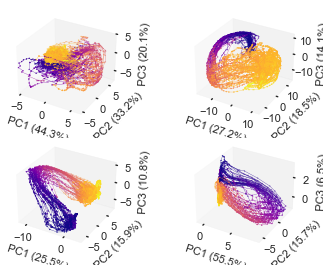

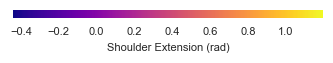

Global shoulder angle range: -0.439 to 1.200 radians


In [13]:
def plot_subplot(data, color_array, title, labels, ax, norm, cmap):
    """Plot 3D trajectory with color-coded points"""
    ax.tick_params(axis="both", which="major", labelsize=8, pad=-4)
    ax.tick_params(axis="z", which="major", labelsize=8, pad=-3)
    ax.set_facecolor("white")
    ax.grid(False)

    x_range = data[:, :, 0].max() - data[:, :, 0].min()
    y_range = data[:, :, 1].max() - data[:, :, 1].min()
    z_range = data[:, :, 2].max() - data[:, :, 2].min()
    ratio = -0.005

    ax.set_xlim(data[:, :, 0].min() - x_range * ratio, data[:, :, 0].max() + x_range * ratio)
    ax.set_ylim(data[:, :, 1].min() - y_range * ratio, data[:, :, 1].max() + y_range * ratio)
    ax.set_zlim(data[:, :, 2].min() - z_range * ratio, data[:, :, 2].max() + z_range * ratio)

    ax.set_xlabel(labels[0], fontsize=8, labelpad=-8, rotation=-16)
    ax.set_ylabel(labels[1], fontsize=8, labelpad=-8, rotation=55)
    ax.set_zlabel(labels[2], fontsize=8, labelpad=-8, rotation=90)

    for n in range(data.shape[0]):
        d = data[n]
        lc_color = cmap(norm(color_array[n, :-1]))
        line_data = np.stack([d[:-1], d[1:]], axis=1)
        lc = Line3DCollection(line_data, colors=lc_color, linewidths=0.2)
        ax.add_collection3d(lc)
        ax.scatter(d[:, 0], d[:, 1], d[:, 2], c=color_array[n], cmap=cmap, norm=norm, s=0.5)

def perform_pca_batch(data, layer_name):
    """Perform PCA on batch activation data"""
    pca = PCA(n_components=3)
    concatenated_data = data.reshape(-1, data.shape[-1])
    pca_result = pca.fit_transform(concatenated_data)
    
    batch_size, timesteps, _ = data.shape
    pca_result = pca_result.reshape(batch_size, timesteps, 3)
    
    explained_variance = np.round(pca.explained_variance_ratio_ * 100, 1)
    print(f"{layer_name} - Explained variance: {explained_variance}")
    return pca_result, explained_variance

# Extract activation data
print("Processing neural network activations...")
decoder_layer_0_data = batch_rollout["activations"]["decoder"]["layer_0"]
decoder_layer_1_data = batch_rollout["activations"]["decoder"]["layer_1"] 
decoder_layer_2_data = batch_rollout["activations"]["decoder"]["layer_2"]
intentions_data = batch_rollout["activations"]["intention"]
qpos_data = batch_rollout["qposes_rollout"]

# Find minimum timesteps
min_timesteps = min(
    decoder_layer_0_data.shape[1],
    decoder_layer_1_data.shape[1], 
    decoder_layer_2_data.shape[1],
    intentions_data.shape[1],
    qpos_data.shape[1]
)

# Truncate all arrays
decoder_layer_0_truncated = decoder_layer_0_data[:, :min_timesteps, :]
decoder_layer_1_truncated = decoder_layer_1_data[:, :min_timesteps, :]
decoder_layer_2_truncated = decoder_layer_2_data[:, :min_timesteps, :]
intentions_truncated = intentions_data[:, :min_timesteps, :]
qpos_data_truncated = qpos_data[:, :min_timesteps, :]

# Perform PCA
decoder_layer_0, vars_decoder_layer_0 = perform_pca_batch(decoder_layer_0_truncated, "Decoder Layer 0")
decoder_layer_1, vars_decoder_layer_1 = perform_pca_batch(decoder_layer_1_truncated, "Decoder Layer 1")
decoder_layer_2, vars_decoder_layer_2 = perform_pca_batch(decoder_layer_2_truncated, "Decoder Layer 2")
intentions_pca, vars_intentions_pca = perform_pca_batch(intentions_truncated, "Intentions")

# Create data with shoulder extension angle
qpos_data_truncated = np.array(qpos_data_truncated)
decoder_0_with_angle = np.concatenate([decoder_layer_0, qpos_data_truncated[:, :, 2][..., np.newaxis]], axis=2)
decoder_1_with_angle = np.concatenate([decoder_layer_1, qpos_data_truncated[:, :, 2][..., np.newaxis]], axis=2)
decoder_2_with_angle = np.concatenate([decoder_layer_2, qpos_data_truncated[:, :, 2][..., np.newaxis]], axis=2)
intentions_with_angle = np.concatenate([intentions_pca, qpos_data_truncated[:, :, 2][..., np.newaxis]], axis=2)

# Dataset configurations
datasets = {
    "intentions": {"data": intentions_with_angle, "title": "Intentions", "var_exp": vars_intentions_pca},
    "decoder_layer_0": {"data": decoder_0_with_angle, "title": "Decoder Layer 1", "var_exp": vars_decoder_layer_0},
    "decoder_layer_1": {"data": decoder_1_with_angle, "title": "Decoder Layer 2", "var_exp": vars_decoder_layer_1},
    "decoder_layer_2": {"data": decoder_2_with_angle, "title": "Decoder Layer 3", "var_exp": vars_decoder_layer_2},
}

# Find global min/max for colorbar
all_shoulder_angles = [config["data"][:, :, 3] for config in datasets.values()]
global_min = min(angles.min() for angles in all_shoulder_angles)
global_max = max(angles.max() for angles in all_shoulder_angles)

# Create colormap
norm = plt.Normalize(global_min, global_max)
cmap = plt.cm.plasma

# Create 2x2 subplot figure
fig = plt.figure(figsize=(3.75, 3))
fig.patch.set_facecolor("white")
subplot_positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, (key, config) in enumerate(datasets.items()):
    ax = fig.add_subplot(2, 2, i + 1, projection="3d")
    
    trajectory_data = config["data"][:, :, :3]
    shoulder_angles = config["data"][:, :, 3]
    var_exp = config["var_exp"]
    
    labels = [f"PC1 ({var_exp[0]:.1f}%)", f"PC2 ({var_exp[1]:.1f}%)", f"PC3 ({var_exp[2]:.1f}%)"]
    
    plot_subplot(trajectory_data, shoulder_angles, config["title"], labels, ax, norm, cmap)
    
    if key == "intentions":
        ax.set_xticks([-5, 0, 5])
        ax.set_yticks([-5, 0, 5])
        ax.set_zticks([-5, 0, 5])

plt.subplots_adjust(left=0.00, right=0.95, top=0.90, bottom=0.10, wspace=0.0, hspace=0.15)
plt.savefig(ckpt_path / "arm_latent_space_2x2_batch.pdf", pad_inches=0.2)
plt.show()

# Create colorbar
fig_cbar, ax_cbar = plt.subplots(figsize=(4, 0.1))
fig_cbar.patch.set_facecolor("white")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=ax_cbar, orientation="horizontal")
plt.tick_params(labelsize=8)
cbar.set_label("Shoulder Extension (rad)", fontsize=8)
ax_cbar.set_frame_on(False)
plt.savefig(ckpt_path / "arm_latent_space_colorbar_batch.pdf", bbox_inches="tight")
plt.show()

print(f"Global shoulder angle range: {global_min:.3f} to {global_max:.3f} radians")
